## Working with WRF NetCDF Files

This example notebook shows how to use `xarray` and `rioxarray` libraries to convert Weather Research and Forecasting Model (WRF) NetCDF files to GeoTIFF files.

References
- [WRF data and Xarray](https://gallery.pangeo.io/repos/NCAR/notebook-gallery/notebooks/Run-Anywhere/WRF/wrf_ex.html)
- [GIS4WRF](https://github.com/GIS4WRF/gis4wrf/)

In [ ]:
import os
import xarray as xr
import rioxarray as rxr
from affine import Affine
import rasterio

In [92]:
file_path = os.path.join('data', 'wrfout_20221211_12.nc')

In [93]:
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:                (Time: 1, south_north: 299, west_east: 299,
                            bottom_top: 35, bottom_top_stag: 36,
                            soil_layers_stag: 4, west_east_stag: 300,
                            south_north_stag: 300, seed_dim_stag: 8,
                            num_turb_layers: 7)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 ...
    XLONG                  (Time, south_north, west_east) float32 ...
    XTIME                  (Time) datetime64[ns] ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag,
                                seed_dim_stag, num_turb_layers
Data variables: (12/253)
    Times                  (Time) |S19 ...
    LU_INDEX               (Time, south_north, west_east) float32 ...
    ZNU                    (Time, bottom_top) float32 ...
    ZNW                    (Time, bottom_top_stag) float32 ...
    ZS                     (Time, soil_layers_stag) float32 ...
    DZS                    (Time, soil_layers_stag) float32 ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 ...
    PC                     (Time, south_north, west_east) float32 ...
    LANDMASK               (Time, south_north, west_east) float32 ...
    LAKEMASK               (Time, south_north, west_east) float32 ...
    SST                    (Time, south_north, west_east) float32 ...
    SST_INPUT              (Time, south_north, west_east) float32 ...
Attributes: (12/132)
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2022-12-09_12:00:00
    SIMULATION_START_DATE:           2022-12-09_12:00:00
    WEST-EAST_GRID_DIMENSION:        300
    SOUTH-NORTH_GRID_DIMENSION:      300
    BOTTOM-TOP_GRID_DIMENSION:       36
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [94]:
da = ds.T2.sel(Time=0)

We pre-process the data to match CF conventions.

In [95]:
da_with_latlon = da.assign_coords(lat=da.coords['XLAT'], lon=da.coords['XLONG'])
da_with_latlon_rename = da_with_latlon.rename({'south_north':'y', 'west_east':'x'})
da_with_latlon_drop = da_with_latlon_rename.drop(['XLAT', 'XLONG', 'XTIME'])
da_wrf_cf = da_with_latlon_drop

In [96]:
da_wrf_cf

<xarray.DataArray 'T2' (y: 299, x: 299)>
array([[298.13858, 298.14594, 298.13937, ..., 297.3881 , 297.5444 , 297.61597],
       [298.148  , 298.12592, 298.0964 , ..., 297.35507, 297.4982 , 297.63043],
       [298.13788, 298.118  , 298.06784, ..., 297.28235, 297.4821 , 297.61166],
       ...,
       [297.84668, 297.8833 , 297.91995, ..., 296.0603 , 296.02353, 296.06952],
       [297.82886, 297.8692 , 297.91772, ..., 296.08255, 296.02176, 296.03564],
       [297.79626, 297.83832, 297.89023, ..., 296.15543, 296.09134, 296.00705]],
      dtype=float32)
Coordinates:
    lat      (y, x) float32 4.8 4.8 4.8 4.8 4.8 ... 25.81 25.81 25.81 25.81
    lon      (y, x) float32 -94.28 -94.21 -94.14 -94.06 ... -72.51 -72.43 -72.36
Dimensions without coordinates: y, x
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

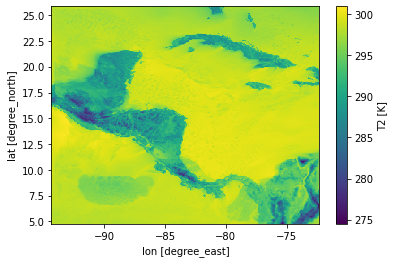

In [97]:
da_wrf_cf.plot(x='lon', y='lat')

To convert the data into a geoereferenced raster, we need to assign it a projection and a transform

WRF datasets store the projection in a dataset attribute named MAP_PROJ. The value is a numeric value that is associated with a different projection. 

```
LAMBERT_CONFORMAL = 1
POLAR_STEREOGRAPHIC = 2
MERCATOR = 3
LAT_LON = 6
```

In [98]:
ds.attrs['MAP_PROJ']

3

This dataset's projection is Lambert Conformal, so we extract the parameters required to construct the projection string.

In [99]:
truelat1 = ds.attrs['TRUELAT1']
truelat2 = ds.attrs['TRUELAT2']
origin_lon = ds.attrs['STAND_LON']
origin_lat = ds.attrs['MOAD_CEN_LAT']
proj_str = ('+proj=lcc +lat_1={lat1} +lat_2={lat2} +lat_0={lat0} +lon_0={lon0} +x_0=0 +y_0=0 +datum=WGS84').format(
                 lat1=truelat1, lat2=truelat2, lon0=origin_lon, lat0=origin_lat)
proj_str

'+proj=lcc +lat_1=12.0 +lat_2=0.0 +lat_0=15.571617126464844 +lon_0=9.0 +x_0=0 +y_0=0 +datum=WGS84'

We have to now compute a transform.

In [100]:
lons_u = ds.XLONG
lons_v = ds.XLONG
lats_u = ds.XLAT
lats_v = ds.XLAT

dim_x = ds.west_east.size
dim_y = ds.south_north.size

lower_left_u = float(lons_u[0,0,0]), float(lats_u[0,0,0])
lower_right_u = float(lons_u[0,0,-1]), float(lats_u[0,0,-1])
lower_left_v = float(lons_v[0,0,0]), float(lats_v[0,0,0])
upper_left_v = float(lons_v[0,-1,0]), float(lats_v[0,-1,0])

from osgeo import osr, ogr
from affine import Affine

def transform_point(point):
    point_geom = ogr.Geometry(ogr.wkbPoint)
    point_geom.AddPoint(point[0], point[1])
    srs_in = osr.SpatialReference()
    srs_in.ImportFromProj4('+proj=latlong +datum=WGS84')
    srs_out = osr.SpatialReference()
    srs_out.ImportFromProj4(proj_str)
    transform = osr.CoordinateTransformation(srs_in, srs_out)
    point_geom.Transform(transform)
    return point_geom.GetX(), point_geom.GetY()

lower_left_u_xy = transform_point(lower_left_u)
lower_right_u_xy = transform_point(lower_right_u)
lower_left_v_xy = transform_point(lower_left_v)
upper_left_v_xy = transform_point(upper_left_v)

dx = (lower_right_u_xy[0] - lower_left_u_xy[0])/dim_x
dy = (upper_left_v_xy[1] - lower_left_v_xy[1])/dim_y
dx, dy

gdal_transform = (lower_left_u_xy[0], dx, 0, lower_left_v_xy[1], 0, dy)
transform = Affine.from_gdal(*gdal_transform)
transform

Affine(7975.4215978364455, 0.0, -11329938.610480601,
       0.0, 7743.009216541448, -117258.08682553655)

In [104]:
da_wrf_cf.rio.write_crs(rasterio.crs.CRS().from_proj4(proj_wkt), inplace=True)
da_wrf_cf.rio.write_transform(transform, inplace=True)
da_wrf_cf.rio.to_raster('data/test.tif')